In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.data_load import load_CIFAR10

# Load matplotlib images inline
%matplotlib inline
# These are important for reloading any code you write in external .py files.
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Versions of used packages:
# python == 3.10.8
# torch == 2.6.0
# numpy == 1.26.4
# transformers == 4.49.0
# Pillow == 9.4.0
# datasets == 3.3.2

# Section #1.1: Vision Transformer


In [2]:
# ======================================================================================================= #
# It might take some time to downliad the dataset the first time
# ======================================================================================================= #

from datasets import load_dataset

ds = load_dataset('benjamin-paine/imagenet-1k-64x64', split='validation')

c:\Users\david\miniconda3\envs\davi_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


data num = 500


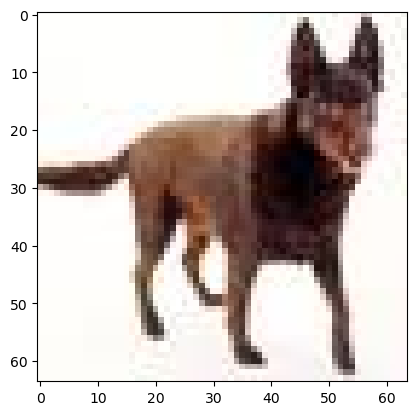

In [3]:
data_num = 500
idx = np.arange(0,50000,int(50000/data_num))
data = ds[idx]
data_num = len(data['image'])
print('data num =', data_num)

plt.imshow(data["image"][250]) #Pillow == 9.4.

In [4]:
# ======================================================================================================= #
# Load the ViT model. See the original paper at: https://arxiv.org/abs/2010.11929
# Documentation of the model can be found at: https://huggingface.co/docs/transformers/model_doc/vit
# ======================================================================================================= #
from transformers import AutoImageProcessor, ViTForImageClassification

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
vit_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", attn_implementation='eager')

Complete the following code to evaluate the validation accuracy of the model.

In [5]:
# ==================================================================================== #
# In this block, we evaluate the accuracy on the validation set of the ViT model.
# To predict the label of an image from the validation set, you need to
#   1) Process the image with
#       inputs = image_processor(image, return_tensors="pt")
#   2) Get the classification score (before softmax) with
#       model(**inputs).logits
#   3) A pytorch tensor will be returned. Predict the label with the largest score.
#   4) Evaluate the accuracy on the validation set
# ==================================================================================== #

val_acc = 0

for i in range(0, data_num):
    if((i+1) % (data_num/100)==0):
        print(f'Progress: {int((i+1)/data_num*100)}%', end='\r')

    inputs = image_processor(data['image'][i], return_tensors="pt")
    logits = vit_model(**inputs).logits

    # top 1 prediction
    predicted_label = logits.argmax(-1).item()
    
    if(data['label'][i] == predicted_label):
        val_acc += 1
        
print()
val_acc /= data_num

print(f"Val acc = {val_acc*100:.2f}%")

#plt.imshow(ds[idx]["image"]) #Pillow == 9.4.0
#plt.show

Progress: 100%
Val acc = 59.60%


# Section 1.2: Attention maps
Now, let's look at the attention map of the model.

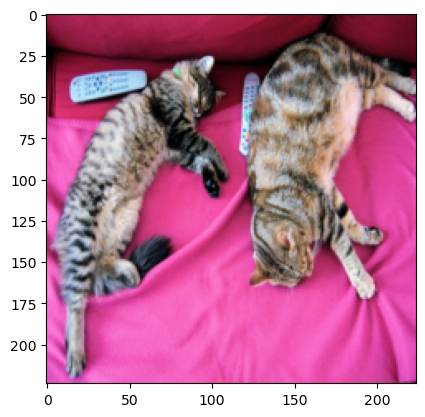

In [6]:
# ==================================================================================== #
# We download a single image with higher resolution from: 
#   https://huggingface.co/datasets/huggingface/cats-image
# This should be a image of two cute cats.
# ==================================================================================== #
cat_img = load_dataset('huggingface/cats-image',trust_remote_code=True)['test']['image'][0]

# Feed the image into the model so that we can get the attention maps
inputs = image_processor(images=cat_img, return_tensors="pt")
outputs = vit_model(**inputs, output_attentions=True)
attentions = outputs.attentions 

# This should show a processed and cropped image from the original image
plt.imshow(inputs['pixel_values'][0].permute(1, 2, 0)/2+0.5)

## Question:
In this problem, the size of each input image is 224x224 pixels. To tokenize each image into patches with each patch with the size of 16x16 pixels. Particularly in the classification task, an additional CLS token is added to the input (this comes from the technique from BERT). The output of the Transformer corresponding to the CLS token will be fed into an MLP for further classifcation task.

In this setting, what will be the total number of tokens for one image?

## Answer:

Since each patch is 16×16, the number of patches per dimension (row or column) is $224 / 16 = 14$. Then, the total number of patches is $14×14 = 196$. Finally, we have the additional CLS token, so in total we have 197 tokens.

Attention maps of the first attention layer:


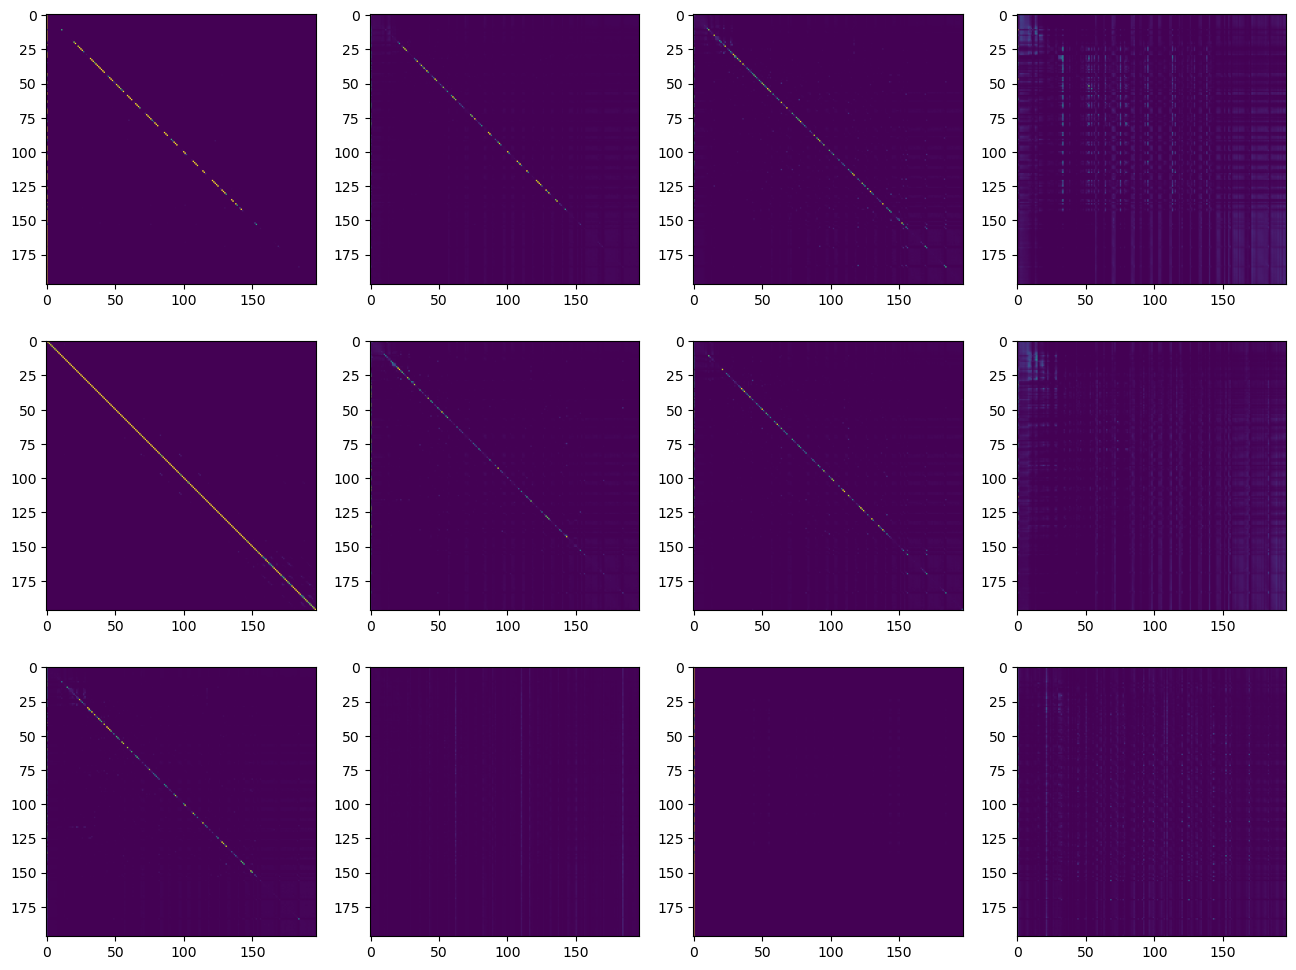

In [7]:
# ==================================================================================== #
# This show the attentions map of the first attention layer.
# ==================================================================================== #

print('Attention maps of the first attention layer:')
ig, axs = plt.subplots(3, 4, figsize=(16, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(attentions[0][0, i, :, :].detach().cpu().numpy())
    #ax.axis('off')

## Questions:
(1) What is the size of one attention map in the figure above? What does each element on the attention map stand for? 

(2) There are 12 attention maps in one attention layer. How is this related to the multi-head attention we learned in class?

## Answer:
(1) Each attention map in the figure is a 197x197 matrix (38,809 total elements). Each element in the map represents the attention weight between one token and another token in the input sequence. The rows and columns represent tokens in the sequence, and higher values indicate stronger relationships between the tokens, meaning higher attention weights.

(2) The 12 attention maps correspond to the 12 attention heads in the same layer, which allow the model to focus on different features and types of relationships in the input sequence simultaneously. The 12 attention maps represent 12 different attention subspaces which are computed in parallel for this layer. This multi-head attention mechanism enables the Transformer model to learn different attention patterns across multiple layers, thereby enhancing its expressive power.

Attention maps of the last attention layer:


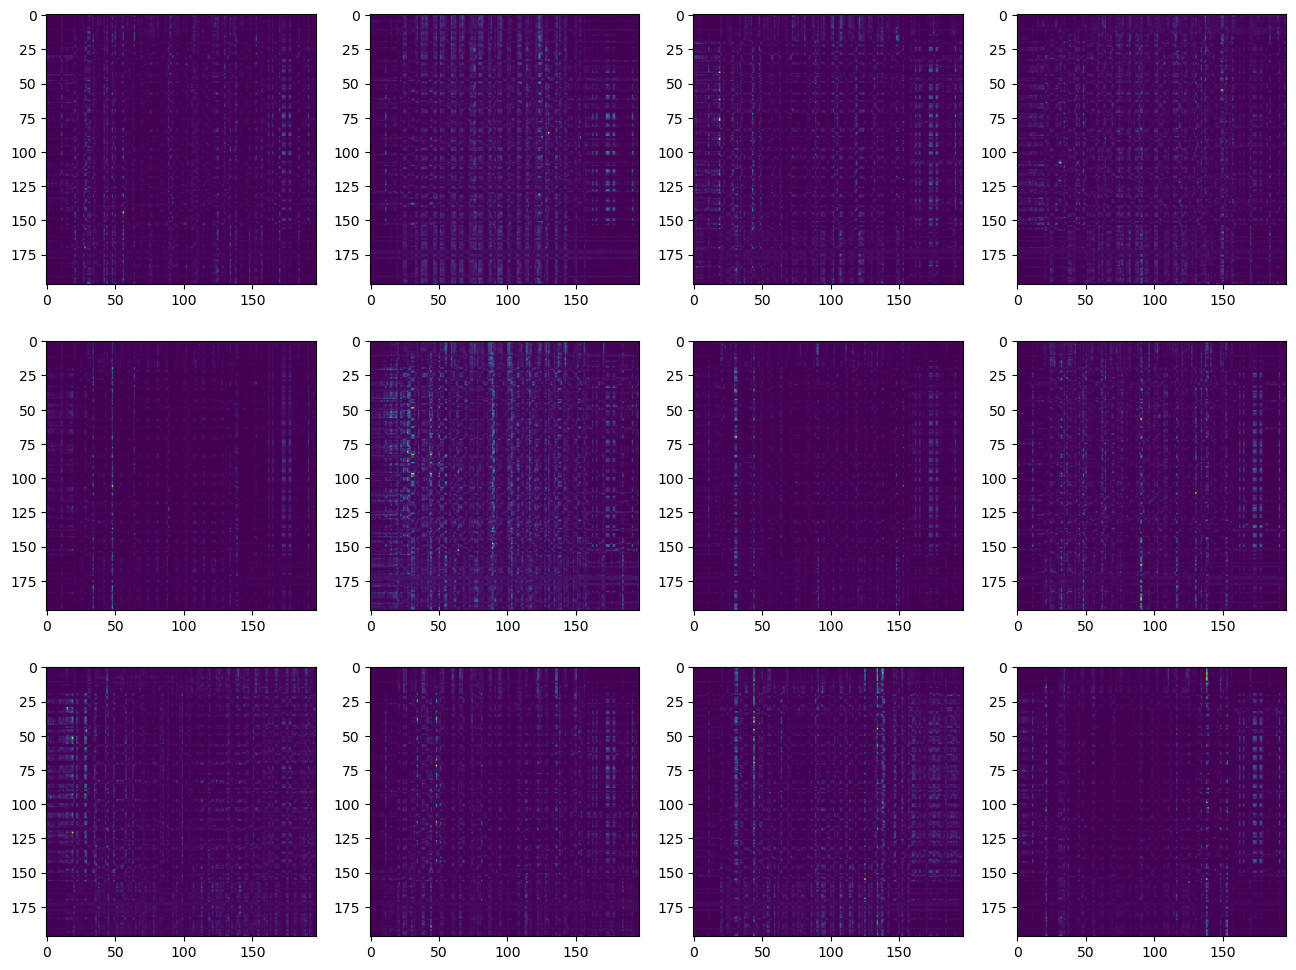

In [8]:
# ==================================================================================== #
# This show the attentions map of the last attention layer.
# ==================================================================================== #

print('Attention maps of the last attention layer:')
ig, axs = plt.subplots(3, 4, figsize=(16, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(attentions[-1][0, i, :, :].detach().cpu().numpy())
    #ax.axis('off')

## Questions:
(1) One advantage of transformers is that they can relate patches (tokens) that are far away from each other. Can we observe this from the attention maps in the last attention layer?

(2) What's the difference between the attention maps in the first attention layer and the last attention layer?

## Answers:
(1) Yes as we can see in each attention map, the pattern of the data forms large values in vertical lines. As previously stated, each column or row represents on token's relation to all tokens. So, any large off-diaganonal value represents a strong relationship between different tokens, similar to a covariance matrix/plot, while the diagonal values are relationships with itself.

(2) The first layer represents the relationships between the input tokens themselves e.g. patches of the image, while the last layer represents relationships between relationships (mapped in previous layers). While the first layer's attention operates on the input tokens' relationships, the attention for later layers operates on these relationships themselves and higher degrees and complexities of relationships. This acts to group/classify parts of the image as well as to form "bigger picture" or more abstracted representations, as well as the relationships between these more abstracted objects.

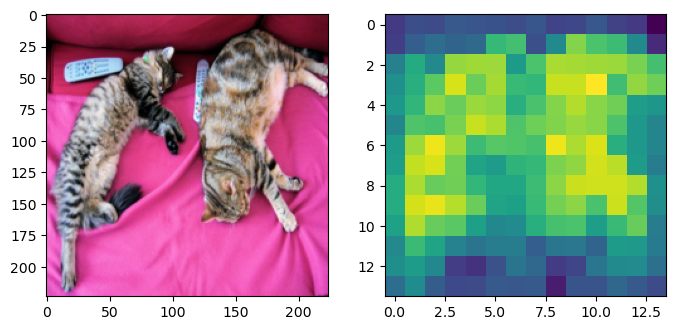

In [9]:
# ==================================================================================== #
# Here is another way to visualize the attention map. This is in the paper: https://arxiv.org/abs/2005.00928
# There are also explanations at: https://medium.com/@nivonl/exploring-visual-attention-in-transformer-models-ab538c06083a
# The so called attention rollout coonsiders the attention effect of all layers.
# We look at the attention values from the CLS token to all the other 14x14 tokens. 
# Thus, we can show the attention effect in a 14x14 plot. 
# ==================================================================================== #


from utils.attention_rollout import attention_rollout
from PIL import ImageFilter, Image

rollout = attention_rollout(attentions)

num_of_patches = 14*14
img_size = 224

cls_attention = rollout[0, 1:, 0]  # Get attention values from [CLS] token to all patches
cls_attention = 1 - cls_attention.reshape(int(np.sqrt(num_of_patches)), int(np.sqrt(num_of_patches)))

# Normalize the attention map for better visualization
cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min())

ig, axs = plt.subplots(1, 2, figsize=(8, 8))
axs[0].imshow(inputs['pixel_values'][0].permute(1, 2, 0)/2+0.5)
axs[1].imshow(cls_attention.detach().numpy())

## Question:

The output of the Transformer corresponding to the CLS token is used for further classification tasks through an MLP. By looking at the attention map above, what can you say about the results? Which tokens make more influence to the prediction result?

## Answers:

The tokens which matter the most correspond to patches where the two cats, and perhaps the remotes are in. This is most likely because they are actual objects that have lots of details and different textures and colors (they have more information and variance), compared to the background which is mostly homogenous. The values are strongly positive, locally where the cats are, as well as on-average, so the output would most likely detect the cats (and possibly the remotes).

# Section 2.1: ResNet-50

In [10]:
from tensorflow.keras.applications import ResNet50 
import tensorflow as tf

# import the ResNet-50 model
rn50_model = ResNet50(weights='imagenet')

# process the data
inputs = []
for img in data['image']:    
    inputs.append( tf.image.resize(tf.keras.utils.img_to_array(img), size=[224,224]) )
inputs = tf.convert_to_tensor(inputs)

# predict the labels with resnet50
pred = rn50_model.predict(inputs)

# print the val acc
val_acc = np.mean( pred.argmax(-1) == np.array(data['label']))
print(f"Val acc = {val_acc*100:.2f}%")

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 742ms/step
Val acc = 18.00%


The accuracy is much lower than what we expect from ResNet50 since we are testing on a donwsized dataset.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


c:\Users\david\miniconda3\envs\davi_env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


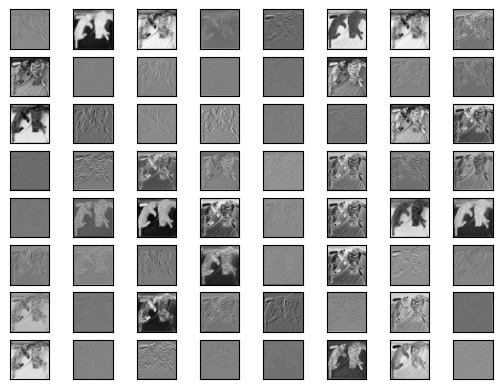

In [11]:
# ==================================================================================== #
# Here, we show the feature maps of ResNet50
# By defult, we are showing the output of the second layer of ResNet-50
# You can play around different layer according to the model structure we show in the next block
# ==================================================================================== #

layer_idx = 2		# plot the output of the desired layer
square = 8			# plot all 64 maps in an 8x8 squares (depends on which layer we are showing)

# set a model with the same begining layers as ResNet-50, end at the desired layer to show its output
fm_model = tf.keras.Model(inputs=rn50_model.inputs, outputs=rn50_model.layers[layer_idx].output)

# get the image
cat_img = load_dataset('huggingface/cats-image')['test']['image'][0]
img = np.expand_dims(tf.image.resize(tf.keras.utils.img_to_array(cat_img), size=[224,224]), axis=0)
img = tf.keras.backend.eval( tf.keras.backend.constant(img) )

# let the image run through the network
feature_maps = fm_model.predict(img)

# show the plos
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
plt.show()

Different subplots correspond to the output of different filters. Each filter might detect different features like edges, textures or specific shapes.

In [12]:


for i in range(len(rn50_model.layers)):
	layer = rn50_model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

1 conv1_pad (None, 230, 230, 3)
2 conv1_conv (None, 112, 112, 64)
3 conv1_bn (None, 112, 112, 64)
4 conv1_relu (None, 112, 112, 64)
7 conv2_block1_1_conv (None, 56, 56, 64)
8 conv2_block1_1_bn (None, 56, 56, 64)
9 conv2_block1_1_relu (None, 56, 56, 64)
10 conv2_block1_2_conv (None, 56, 56, 64)
11 conv2_block1_2_bn (None, 56, 56, 64)
12 conv2_block1_2_relu (None, 56, 56, 64)
13 conv2_block1_0_conv (None, 56, 56, 256)
14 conv2_block1_3_conv (None, 56, 56, 256)
15 conv2_block1_0_bn (None, 56, 56, 256)
16 conv2_block1_3_bn (None, 56, 56, 256)
17 conv2_block1_add (None, 56, 56, 256)
18 conv2_block1_out (None, 56, 56, 256)
19 conv2_block2_1_conv (None, 56, 56, 64)
20 conv2_block2_1_bn (None, 56, 56, 64)
21 conv2_block2_1_relu (None, 56, 56, 64)
22 conv2_block2_2_conv (None, 56, 56, 64)
23 conv2_block2_2_bn (None, 56, 56, 64)
24 conv2_block2_2_relu (None, 56, 56, 64)
25 conv2_block2_3_conv (None, 56, 56, 256)
26 conv2_block2_3_bn (None, 56, 56, 256)
27 conv2_block2_add (None, 56, 56, 256)
28 